In [156]:
from svg.path import parse_path
from xml.dom import minidom
import matplotlib.pyplot as plt
import numpy as np

class SvgData:
    def __init__(self, filename, limitlist):
        self.filename = filename
        self.xyrefvalues = np.array(limitlist) ###
        self.positions =['x1', 'x2', 'y1', 'y2']

        self.doc = minidom.parse(self.filename)

        self.figpaths = self.get_paths()
        self.xyrefpoints = self.get_refpoints()
        self.ref_points, self.real_points = self.get_points2()

        self.xtrafo = self.get_trafo(self.xyrefpoints[:2, 0], self.xyrefvalues[:2])
        self.ytrafo = self.get_trafo(self.xyrefpoints[2:, 1], self.xyrefvalues[2:])
        #print(self.xtrafo)
        self.doc.unlink()
        self.get_parsed()
        
    def get_parsed(self):
        self.allresults = {}
        for pathid, pvals in self.figpaths.items():
            self.allresults[pathid] = self.get_real_values(pvals)

    def plot(self):
        resdict = self.allresults
        for i, v in resdict.items():
            plt.plot(v[0], v[1], label=i)

        plt.legend()
        plt.tight_layout()
        plt.show()

    def get_trafo(self, xrefpath, xrefvalues):
        # we assume a rectangular plot
        # xvalue = mrefx * (xpath -xrefpath0 ) + xrefvalue0
        print(xrefpath, xrefvalues)
        mrefx = (xrefvalues[1] - xrefvalues[0]) / (xrefpath[1] - xrefpath[0])
        trafo = lambda xpathdata: mrefx * (xpathdata - xrefpath[0]) + xrefvalues[0]
        return trafo

    def get_real_values(self, xpathdata):
        xnorm = self.xtrafo(xpathdata[:, 0])
        ynorm = self.ytrafo(xpathdata[:, 1])
        return np.array([xnorm, ynorm])

    def guess_xypoints_ordered_keys(self, point_strings):
        # Here we get first the rightmost point on x and then the highest point on y
        # We assume these are the endpoints of our plot
        # Then we choose the point with minimum y distance as the lower end xpoint.
        # This should work in most cases, and for close points with x,y axis meeting e.g. should not matter?!.
        # careful: y is measured from the top in svg file, how great is that!
        rp_keys = list(point_strings.keys())

        if len(point_strings) != 4:
            print("Could not find 4 reference points for the axis." + \
                  "Please Check that you put 4 Ellipsis reference points in your svg figure." +
                  "The found Ellipsis points have these ids: ", point_strings)
            raise Exception


        rp_vals = np.array([point_strings[r] for r in rp_keys])



        xmax_ind = np.argmax(rp_vals[:, 0])
        # careful: y is measured from the top in svg file, how great is that!
        ymax_ind = np.argmin(rp_vals[:, 1])

        xmin_ind = np.argsort([ np.linalg.norm(v) for v in np.array(rp_vals) - np.array(rp_vals[xmax_ind])])[1]
        
        ymin_ind = np.setdiff1d([0, 1, 2, 3], [xmax_ind, ymax_ind, xmin_ind]).tolist()
        if len(ymin_ind) > 1:
            print("Could not resolve automatically the axis points.", ymin_ind)
            raise Exception
        else:
            ymin_ind = ymin_ind[0]
        return [rp_keys[l] for l in [xmin_ind, xmax_ind, ymin_ind, ymax_ind]]

    def get_refpoints(self):
        point_strings = self.get_points()
        #print("point_strings", point_strings)
        point_strings_ordered_keys = self.guess_xypoints_ordered_keys(point_strings)

        xyrefs = np.array([point_strings[name] for name in point_strings_ordered_keys])

        return xyrefs

    def get_paths(self):
        path_strings = [(path.getAttribute('id'), path.getAttribute('d')) for path
                        in self.doc.getElementsByTagName('path')]

        xypaths_all = {path_string[0]: self.parse_pathstring(path_string[1]) for path_string in path_strings}

        return xypaths_all

    def get_points(self):
        
        point_strings={}
        
        for shape in ['circle', 'ellipse']:
            for path in self.doc.getElementsByTagName(shape):
                title = path.getElementsByTagName("title")
                #titletext = self.getText(title.childNodes)
                titletext = title[0].firstChild.data
                position, value = titletext[:2], float(titletext[3:])
                # print(f'position: {position}, value: {value}')
                #for node in title:
                #    print(node.firstChild.data)
                #point_strings[path.getAttribute('id')] = [float(path.getAttribute('cx')), float(path.getAttribute('cy'))] 
                point_strings[position] = [float(path.getAttribute('cx')), float(path.getAttribute('cy'))] 
        
        return point_strings
    
    def get_points2(self):
        '''Creates:
        ref_points: relative values of the spheres/eclipses in the svg file.
        real_points: real values of the points given in the title text of the svg file.'''
        ref_points = {}
        real_points = {}
        
        for shape in ['circle', 'ellipse']:
            for path in self.doc.getElementsByTagName(shape):
                title = path.getElementsByTagName("title")
                titletext = title[0].firstChild.data
                position, value = titletext[:2], float(titletext[3:])
                
                ref_points[position] = [float(path.getAttribute('cx')), float(path.getAttribute('cy'))] 
                real_points[position] = value
        
        print('Ref points: ', ref_points)
        print('point values: ',real_points)
        return ref_points, real_points

    def parse_pathstring(self, path_string):
        path = parse_path(path_string)
        posxy = []
        for e in path:
            x0 = e.start.real
            y0 = e.start.imag
            x1 = e.end.real
            y1 = e.end.imag
            posxy.append([x0, y0])

        return np.array(posxy)


Ref points:  {'x1': [24.187801, 77.067566], 'x2': [55.746693, 76.919739], 'y1': [13.34248, 66.401375], 'y2': [13.404156, 46.573719]}
point values:  {'x1': 0.0, 'x2': 100.0, 'y1': -10.0, 'y2': 0.1}
[24.187801 55.746693] [  0. 100.]
[66.401375 46.573719] [-10.    0.1]


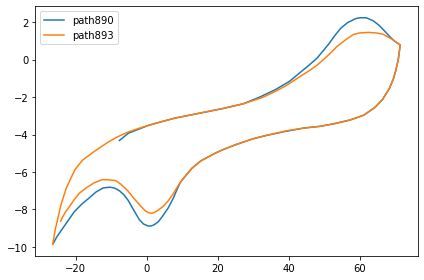

In [157]:
filename='Ni111_NaOH_Beden1985_Fig2c.svg'
svg = SvgData(filename, [0,0.6,-10,0.1])
svg.plot()

In [154]:
from svg.path import parse_path
from xml.dom import minidom
import matplotlib.pyplot as plt
import numpy as np

class SvgData:
    def __init__(self, filename, limitlist):
        self.filename = filename
        self.xyrefvalues = np.array(limitlist) ###
        #self.positions =['x1', 'x2', 'y1', 'y2']

        self.doc = minidom.parse(self.filename)

        self.figpaths = self.get_paths()
        
        self.ref_points, self.real_points = self.get_points2()
        #self.xyrefpoints = self.get_refpoints()
        
        #self.xtrafo = self.get_trafo(self.xyrefpoints[:2, 0], self.xyrefvalues[:2])
        #self.ytrafo = self.get_trafo(self.xyrefpoints[2:, 1], self.xyrefvalues[2:])
        
        self.xtrafo = self.get_trafo([self.ref_points['x1'][0], self.ref_points['x2'][0]], [self.real_points['x1'], self.real_points['x2']])
        self.ytrafo = self.get_trafo([self.ref_points['y1'][1], self.ref_points['y2'][1]], [self.real_points['y1'], self.real_points['y2']])
        
        #print(self.xtrafo)
        self.doc.unlink()
        self.get_parsed()
        
        
    def get_parsed(self):
        '''cuve function'''
        self.allresults = {}
        for pathid, pvals in self.figpaths.items():
            self.allresults[pathid] = self.get_real_values(pvals)

    def plot(self):
        '''curve function'''
        resdict = self.allresults
        for i, v in resdict.items():
            plt.plot(v[0], v[1], label=i)

        plt.legend()
        plt.tight_layout()
        plt.show()

    def get_trafo(self, xrefpath, xrefvalues):
        # we assume a rectangular plot
        # xvalue = mrefx * (xpath -xrefpath0 ) + xrefvalue0
        print('xrefpath ', xrefpath, 'xrefvalues ', xrefvalues)
        mrefx = (xrefvalues[1] - xrefvalues[0]) / (xrefpath[1] - xrefpath[0])
        trafo = lambda xpathdata: mrefx * (xpathdata - xrefpath[0]) + xrefvalues[0]
        return trafo
    
    A
    
    def get_real_values(self, xpathdata):
        xnorm = self.xtrafo(xpathdata[:, 0])
        ynorm = self.ytrafo(xpathdata[:, 1])
        return np.array([xnorm, ynorm])

    def guess_xypoints_ordered_keys(self, point_strings):
        # Here we get first the rightmost point on x and then the highest point on y
        # We assume these are the endpoints of our plot
        # Then we choose the point with minimum y distance as the lower end xpoint.
        # This should work in most cases, and for close points with x,y axis meeting e.g. should not matter?!.
        # careful: y is measured from the top in svg file, how great is that!
        rp_keys = list(point_strings.keys())

        if len(point_strings) != 4:
            print("Could not find 4 reference points for the axis." + \
                  "Please Check that you put 4 Ellipsis reference points in your svg figure." +
                  "The found Ellipsis points have these ids: ", point_strings)
            raise Exception


        rp_vals = np.array([point_strings[r] for r in rp_keys])
        print('keys: ',rp_keys)
        #rp_vals = np.array([point_strings[r] for r in self.positions])
        #rp_vals = [value for value in self.ref_points.values()]


        xmax_ind = np.argmax(rp_vals[:, 0])
        # careful: y is measured from the top in svg file, how great is that!
        ymax_ind = np.argmin(rp_vals[:, 1])

        xmin_ind = np.argsort([ np.linalg.norm(v) for v in np.array(rp_vals) - np.array(rp_vals[xmax_ind])])[1]
        
        ymin_ind = np.setdiff1d([0, 1, 2, 3], [xmax_ind, ymax_ind, xmin_ind]).tolist()
        if len(ymin_ind) > 1:
            print("Could not resolve automatically the axis points.", ymin_ind)
            raise Exception
        else:
            ymin_ind = ymin_ind[0]
        return [rp_keys[l] for l in [xmin_ind, xmax_ind, ymin_ind, ymax_ind]]

    #def get_refpoints(self):
    #    point_strings = self.get_points()
    #    #print("point_strings", point_strings)
    #    #point_strings_ordered_keys = self.guess_xypoints_ordered_keys(point_strings)
    #    point_strings_ordered_keys = self.guess_xypoints_ordered_keys(self.ref_points)

    #    xyrefs = np.array([point_strings[name] for name in point_strings_ordered_keys])
    #   print('xy refs: ', xyrefs)
    #   return xyrefs

    def get_paths(self):
        path_strings = [(path.getAttribute('id'), path.getAttribute('d')) for path
                        in self.doc.getElementsByTagName('path')]

        xypaths_all = {path_string[0]: self.parse_pathstring(path_string[1]) for path_string in path_strings}

        return xypaths_all

    def get_points(self):
        
        point_strings={}
        
        for shape in ['circle', 'ellipse']:
            for path in self.doc.getElementsByTagName(shape):
                title = path.getElementsByTagName("title")
                #titletext = self.getText(title.childNodes)
                titletext = title[0].firstChild.data
                position, value = titletext[:2], float(titletext[3:])
                # print(f'position: {position}, value: {value}')
                #for node in title:
                #    print(node.firstChild.data)
                #point_strings[path.getAttribute('id')] = [float(path.getAttribute('cx')), float(path.getAttribute('cy'))] 
                point_strings[position] = [float(path.getAttribute('cx')), float(path.getAttribute('cy'))] 
        
        return point_strings
    
    def get_points2(self):
        '''Creates:
        ref_points: relative values of the spheres/eclipses in the svg file.
        real_points: real values of the points given in the title text of the svg file.'''
        ref_points = {}
        real_points = {}
        
        for shape in ['circle', 'ellipse']:
            for path in self.doc.getElementsByTagName(shape):
                title = path.getElementsByTagName("title")
                titletext = title[0].firstChild.data
                position, value = titletext[:2], float(titletext[3:])
                
                ref_points[position] = [float(path.getAttribute('cx')), float(path.getAttribute('cy'))] 
                real_points[position] = value
        
        print('Ref points: ', ref_points)
        print('point values: ',real_points)
        return ref_points, real_points

    def parse_pathstring(self, path_string):
        path = parse_path(path_string)
        posxy = []
        for e in path:
            x0 = e.start.real
            y0 = e.start.imag
            x1 = e.end.real
            y1 = e.end.imag
            posxy.append([x0, y0])

        return np.array(posxy)
    

Ref points:  {'x1': [24.187801, 77.067566], 'x2': [55.746693, 76.919739], 'y1': [13.34248, 66.401375], 'y2': [13.404156, 46.573719]}
point values:  {'x1': 0.0, 'x2': 100.0, 'y1': -10.0, 'y2': 0.1}
xrefpath  [24.187801, 55.746693] xrefvalues  [0.0, 100.0]
xrefpath  [66.401375, 46.573719] xrefvalues  [-10.0, 0.1]


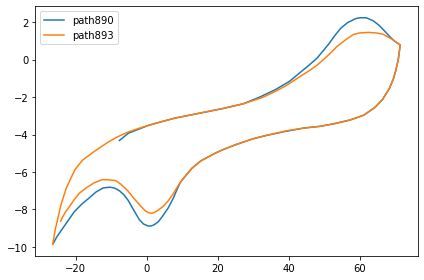

In [155]:
filename='Ni111_NaOH_Beden1985_Fig2c.svg'
svg = SvgData(filename, [0,1,0,100])
svg.plot()

In [98]:
A = {'a': 1, 'b': 2}
for value in A.values():
    print(value)

1
2


In [178]:
from svg.path import parse_path
from xml.dom import minidom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

class SvgData:
    def __init__(self, filename, xlabel=None, ylabel=None):
        '''filename: should be a valid svg file created according to the documentation'''
        self.filename = filename
        
        self.xlabel = xlabel or 'x'
        self.ylabel = ylabel or 'y'
        
        self.doc = minidom.parse(self.filename)

        self.figpaths = self.get_paths()
        
        self.ref_points, self.real_points = self.get_points()
        
        self.xtrafo = self.get_trafo([self.ref_points['x1'][0], self.ref_points['x2'][0]], [self.real_points['x1'], self.real_points['x2']])
        self.ytrafo = self.get_trafo([self.ref_points['y1'][1], self.ref_points['y2'][1]], [self.real_points['y1'], self.real_points['y2']])
        
        self.doc.unlink()
        self.get_parsed()
        self.create_df()
        
    
    def get_points(self):
        '''Creates:
        ref_points: relative values of the spheres/eclipses in the svg file.
        real_points: real values of the points given in the title text of the svg file.'''
        ref_points = {}
        real_points = {}
        
        for shape in ['circle', 'ellipse']:
            for path in self.doc.getElementsByTagName(shape):
                title = path.getElementsByTagName("title")
                titletext = title[0].firstChild.data
                position, value = titletext[:2], float(titletext[3:])
                
                ref_points[position] = [float(path.getAttribute('cx')), float(path.getAttribute('cy'))] 
                real_points[position] = value
        
        print('Ref points: ', ref_points)
        print('point values: ',real_points)
        return ref_points, real_points
        
    def get_parsed(self):
        '''cuve function'''
        self.allresults = {}
        for pathid, pvals in self.figpaths.items():
            self.allresults[pathid] = self.get_real_values(pvals)
    

    def get_trafo(self, xrefpath, xrefvalues):
        # we assume a rectangular plot
        # xvalue = mrefx * (xpath -xrefpath0 ) + xrefvalue0
        print('xrefpath ', xrefpath, 'xrefvalues ', xrefvalues)
        mrefx = (xrefvalues[1] - xrefvalues[0]) / (xrefpath[1] - xrefpath[0])
        trafo = lambda xpathdata: mrefx * (xpathdata - xrefpath[0]) + xrefvalues[0]
        return trafo
    
    def get_real_values(self, xpathdata):
        xnorm = self.xtrafo(xpathdata[:, 0])
        ynorm = self.ytrafo(xpathdata[:, 1])
        return np.array([xnorm, ynorm])

    def get_paths(self):
        path_strings = [(path.getAttribute('id'), path.getAttribute('d')) for path
                        in self.doc.getElementsByTagName('path')]

        xypaths_all = {path_string[0]: self.parse_pathstring(path_string[1]) for path_string in path_strings}

        return xypaths_all    
    

    def parse_pathstring(self, path_string):
        path = parse_path(path_string)
        posxy = []
        for e in path:
            x0 = e.start.real
            y0 = e.start.imag
            x1 = e.end.real
            y1 = e.end.imag
            posxy.append([x0, y0])

        return np.array(posxy)
    
    def create_df(self):
        data = [self.allresults[list(self.allresults)[idx]].transpose() for idx, i in enumerate(self.allresults)]
        self.dfs = [pd.DataFrame(data[idx],columns=[self.xlabel,self.ylabel]) for idx, i in enumerate(data)]
        #for df in self.dfs:
        #    df['t'] = self.create_time_axis(df)
            #df = df[['t','U','I']].copy() #reorder columns does not work
    
    def plot(self):
        '''curve function'''
        #resdict = self.allresults
        #for i, v in resdict.items():
        #    plt.plot(v[0], v[1], label=i)
            
        fig, ax = plt.subplots(1,1)
        for i, df in enumerate(self.dfs):
            df.plot(x=self.xlabel, y=self.ylabel, ax=ax, label=f'curve {i}') 
        # do we want the path in the legend as it was in the previous version?
        #plt.legend()
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        plt.tight_layout()
        plt.show()
    

Ref points:  {'x1': [24.187801, 77.067566], 'x2': [55.746693, 76.919739], 'y1': [13.34248, 66.401375], 'y2': [13.404156, 46.573719]}
point values:  {'x1': 0.0, 'x2': 0.6, 'y1': -0.2, 'y2': 0.1}
xrefpath  [24.187801, 55.746693] xrefvalues  [0.0, 0.6]
xrefpath  [66.401375, 46.573719] xrefvalues  [-0.2, 0.1]


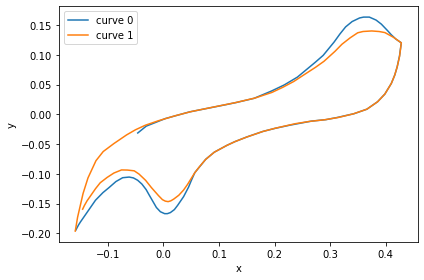

In [179]:
filename='Ni111_NaOH_Beden1985_Fig2c.svg'
svg = SvgData(filename)#, [0,1,0,100])
svg.plot()

In [147]:
svg.allresults

{'path890': array([[-0.04604799, -0.04604799, -0.04414248, ..., -0.15596536,
         -0.15680741, -0.15764945],
        [-0.03123733, -0.03123733, -0.02979979, ..., -0.19166572,
         -0.19314017, -0.19461463]]),
 'path893': array([[-0.1584915 , -0.1584915 , -0.15826696, ..., -0.14467624,
         -0.14493423, -0.14519223],
        [-0.19608907, -0.19608907, -0.194793  , ..., -0.15826663,
         -0.15877213, -0.15927764]])}

In [148]:
svg.figpaths

{'path890': array([[21.765762, 55.247481],
        [21.765762, 55.247481],
        [21.865988, 55.152471],
        ...,
        [15.984311, 65.850544],
        [15.940021, 65.947994],
        [15.895731, 66.045444]]),
 'path893': array([[15.851441, 66.142893],
        [15.851441, 66.142893],
        [15.863251, 66.057233],
        ...,
        [16.578098, 63.643125],
        [16.564528, 63.676535],
        [16.550958, 63.709945]])}

Ref points:  {'x1': [24.187801, 77.067566], 'x2': [55.746693, 76.919739], 'y1': [13.34248, 66.401375], 'y2': [13.404156, 46.573719]}
point values:  {'x1': 0.0, 'x2': 0.6, 'y1': -0.2, 'y2': 0.1}
xrefpath  [24.187801, 55.746693] xrefvalues  [0.0, 0.6]
xrefpath  [66.401375, 46.573719] xrefvalues  [-0.2, 0.1]


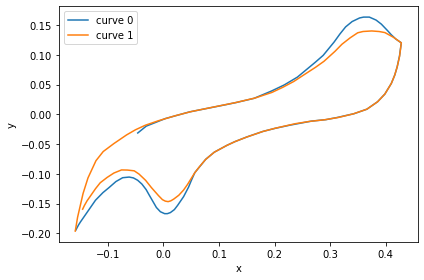

In [180]:
from svgdigitizer import SvgData
filename='Ni111_NaOH_Beden1985_Fig2c.svg'
svg = SvgData(filename)#, [0,1,0,100])
svg.plot()